#Import

In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import json
import zipfile

from PIL import Image
from six import BytesIO
from six.moves.urllib.request import urlopen

In [ ]:
# Clone the tensorflow models repository
%%capture
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [ ]:
!pip install kaggle

# Define username and public api key gathered from your Kaggle Account
KAGGLE_USERNAME = 'eulerismygod'
KAGGLE_PUBLIC_API_KEY = '81c12f2b229dae9c3469e25df4c04838'
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_PUBLIC_API_KEY}

!mkdir /root/.kaggle

# Create .kaggle/kaggle.json file at the root for Kaggle API reference
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Download dataset and extract it to adversarial-person/data
!chmod 600 root/.kaggle/kaggle.json
!kaggle datasets download -d jcoral02/inriaperson

with zipfile.ZipFile('inriaperson.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/inriaperson/')

!rm inriaperson.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: cannot access 'root/.kaggle/kaggle.json': No such file or directory
 99% 578M/582M [00:04<00:00, 123MB/s]
100% 582M/582M [00:04<00:00, 139MB/s]


In [ ]:
%matplotlib inline

#Util

In [ ]:
def _load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape [img_height, img_width, 3]
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3))

In [ ]:
def plot_detections(img, boxes, classes, scores, category_index, size=(6, 6)):
  """Wrapper function for visualize_boxes_and_labels_on_image_array"""
  image_np_with_annotations = img.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  
  plt.figure(figsize=size)
  plt.imshow(image_np_with_annotations)


def dataset_sanity_check(img_list_np, gt_list_np, class_list_np, category_index, index=None):

  print("Image list length:      ", len(img_list_np))
  print("Groundtruth list length:", len(gt_list_np))

  if len(img_list_np) != len(gt_list_np):
    print("ERROR: Image and groundtruth list doesn't match")
    return

  length = len(img_list_np)

  if index is None:
    index = random.randrange(length)
  elif index >= length:
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(length)

  img = img_list_np[index]
  gt = gt_list_np[index]
  classes = class_list_np[index].astype(np.uint32)
  scores = np.ones(shape=(len(classes)))

  plot_detections(img, gt, classes, scores, category_index)

def detection_model_sanity_check(model, img_list_ts, category_index, index=None):
  """Plot the detection boxes of a selected image
  """

  if index is None:
    index = random.randrange(len(img_list_ts))
  elif index >= len(img_list_ts):
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(len(img_list_ts))

  preprocessed_image, shapes = model.preprocess(img_list_ts[index])
  prediction_dict = model.predict(preprocessed_image, shapes)
  detections = model.postprocess(prediction_dict, shapes)

  img = img_list_ts[index].numpy().copy()

  plot_detections(
      img_list_ts[index].numpy().copy().astype(int)[0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index)

#Model

In [ ]:
def download_model(model_name, model_date):
  """Downloaded files are stored in Keras cache"""
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(fname=model_name,
                                      origin=base_url + model_date + '/' + model_file,
                                      untar=True)
  return str(model_dir)

# Download and extract model
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

# Load pipeline config and build a detection model
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

353902592/353893393 [==============================] - 3s 0us/step


#Init


In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
CATEGORY_INDEX_SIZE = 90
CATEGORY_LABEL_ID_OFFSET = 1
CATEGORY_PERSON_CLASS_ID = 1
CATEGORY_INDEX_COCO = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
# for item in CATEGORY_INDEX_COCO.items():
#   print(item)

In [ ]:
def fetch(img_dir):
  """Convert image dataset into Python lists of images

  Return
    img_list_np: A list of np.uint8 array with shape [Height, Width, 3]
  """
  img_list_np = []
  directory = os.fsencode(img_dir)
  for file in os.listdir(directory):
    filename = os.fsdecode(file)
    file_path = img_dir + '/' + filename
    img_list_np.append(_load_image_into_numpy_array(file_path))

  return img_list_np

1


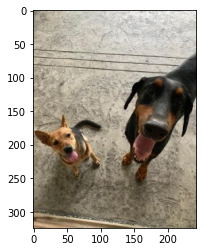

In [ ]:
test_img_dir = '/content/fake_dataset'
test_img_np = fetch(test_img_dir)
print(len(test_img_np))
plt.imshow(test_img_np[0])

#Tensorfy

In [ ]:
def tensorfy_and_resize_img(img_list_np, size):
  """Convert to tensor and resize to fit detect()'s input signature which is
  tf.float32 shape [1, 1024, 1024, 3]
  """
  img_list_ts = []
  for img in img_list_np:
    img_list_ts.append(tf.expand_dims(tf.image.resize_with_pad(tf.convert_to_tensor(img, tf.float32), size, size), axis=0))

  return img_list_ts

test_img_ts = tensorfy_and_resize_img(test_img_np, 1024)

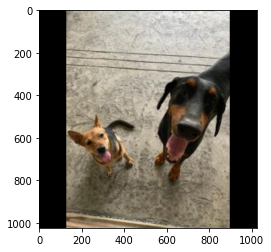

In [ ]:
plt.imshow(test_img_ts[0].numpy().astype(np.int32)[0])

In [ ]:
def get_label_fn(model, img_size):

  # Create a graph execution for faster future use
  @tf.function(input_signature=(
      tf.TensorSpec(shape=(1, img_size, img_size, 3), dtype=tf.float32),
  ))
  def model_selfdetect(input_tensor):
    preprocessed_image, shapes = model.preprocess(input_tensor)
    prediction_dict = model.predict(preprocessed_image, shapes)
    return model.postprocess(prediction_dict, shapes)

  def label(img_list_ts):
    """Generate groundtruth boxes, class using detection model
    """
    box_list_np = []
    class_list_np = []

    for id, img in enumerate(img_list_ts):
      predictions = model_selfdetect(img)
      n = int(tf.squeeze(predictions['num_detections']))
      boxes = np.zeros(shape=(n,4))
      classes = np.zeros(shape=n)
      e = 0

      for i in range(n):
        if(tf.squeeze(predictions['detection_scores']).numpy()[i] > 0.8):
          e += 1
          boxes[i] = tf.squeeze(predictions['detection_boxes']).numpy()[i]
          classes[i] = tf.squeeze(predictions['detection_classes']).numpy()[i] + 1

      box_list_np.append(boxes[0:e])
      class_list_np.append(classes[0:e])

    return box_list_np, class_list_np

  return label

In [ ]:
label = get_label_fn(detection_model, 1024)

In [ ]:
test_box_np, test_class_np = label(test_img_ts)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


Image list length:       1
Groundtruth list length: 1


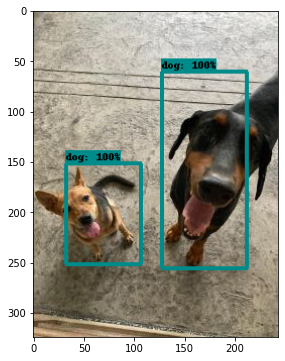

In [ ]:
dataset_sanity_check(test_img_np, test_box_np, test_class_np, CATEGORY_INDEX_COCO)

In [ ]:
print(len(test_box_np))
print(len(test_class_np))
print(len(test_img_ts))

1
1
1


#Filter

In [ ]:
def filter_no_person(img_list_ts, box_list_np, class_list_np, person_class_id):
  """Remove data with no person detected
  """
  num_of_removed_item = 0
  for id in range(len(img_list_ts)):
    num_of_person = 0
    for c in class_list_np[id - num_of_removed_item]:
      if c == person_class_id:
        num_of_person += 1

    if num_of_person == 0:
      # Remove list[id]
      del img_list_ts[id - num_of_removed_item]
      del box_list_np[id - num_of_removed_item]
      del class_list_np[id - num_of_removed_item]
      num_of_removed_item += 1
  
  return img_list_ts, box_list_np, class_list_np

In [ ]:
test_img_ts, test_box_np, test_class_np = filter_no_person(test_img_ts, test_box_np, test_class_np, CATEGORY_PERSON_CLASS_ID)

In [ ]:
print(len(test_box_np))
print(len(test_class_np))
print(len(test_img_ts))

0
0
0


In [ ]:
def filter_multiple_person(img_list_ts, box_list_np, class_list_np, person_class_id):
  """Remove data with more than one person detected
  """

  num_of_removed_item = 0
  for id in range(len(img_list_ts)):
    num_of_person = 0
    for c in class_list_np[id - num_of_removed_item]:
      if c == person_class_id:
        num_of_person += 1
        if num_of_person > 1:
          # Remove list[id]
          del img_list_ts[id - num_of_removed_item]
          del box_list_np[id - num_of_removed_item]
          del class_list_np[id - num_of_removed_item]
          num_of_removed_item += 1
          break
  
  return img_list_ts, box_list_np, class_list_np

In [ ]:
test_img_ts, test_box_np, test_class_np = filter_multiple_person(test_img_ts, test_box_np, test_class_np, CATEGORY_PERSON_CLASS_ID)

In [ ]:
print(len(test_box_np))
print(len(test_class_np))
print(len(test_img_ts))

1
1
1


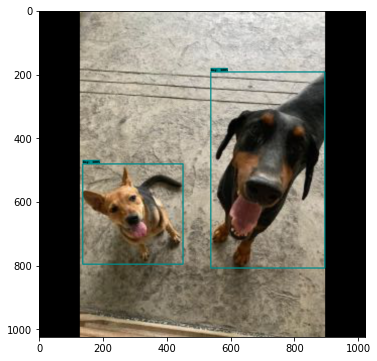

In [ ]:
detection_model_sanity_check(detection_model, test_img_ts, CATEGORY_INDEX_COCO, index=None)

In [ ]:
def filter_single_detection(img_list_ts, box_list_np, class_list_np):
  """Remove data with only one detection, including non-person class
  This is a workaround in model.provide_groundtruth() function where function
  cannot receive empty list as argument
  """

  num_of_removed_item = 0
  for id in range(len(img_list_ts)):
    if len(class_list_np[id - num_of_removed_item]) == 1:
      # Remove list[id]
      del img_list_ts[id - num_of_removed_item]
      del box_list_np[id - num_of_removed_item]
      del class_list_np[id - num_of_removed_item]
      num_of_removed_item += 1
      break
  
  return img_list_ts, box_list_np, class_list_np

In [ ]:
test_img_ts, test_box_np, test_class_np = filter_single_detection(test_img_ts, 
                                                                  test_box_np, 
                                                                  test_class_np)

In [ ]:
print(len(test_box_np))
print(len(test_class_np))
print(len(test_img_ts))

1
1
1


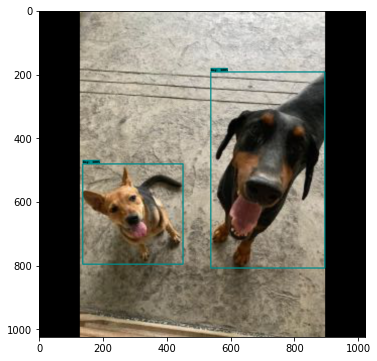

In [ ]:
detection_model_sanity_check(detection_model, test_img_ts, CATEGORY_INDEX_COCO, index=None)

# Mallicious Groundtruth

In [ ]:
def generate_mallicious_gt(box_list_np, class_list_np, person_class_id):
  """Select the person class with highest confidence and remove it from
  the dataset list, return the detection's bounding boxes to generate
  adversarial image
  """
  adv_box_list_np = []

  for i in range(len(box_list_np)):
    for j in range(len(class_list_np[i])):
      if class_list_np[i][j] == person_class_id:
        adv_box_list_np.append(box_list_np[i][j])
        box_list_np[i] = np.delete(box_list_np[i], j, axis=0)
        class_list_np[i] = np.delete(class_list_np[i], j)
        break
  
  return box_list_np, class_list_np, adv_box_list_np

In [ ]:
test_box_np, test_class_np, test_adv_box_np = generate_mallicious_gt(test_box_np, test_class_np, CATEGORY_PERSON_CLASS_ID)

In [ ]:
print(len(test_box_np))
print(len(test_class_np))
print(len(test_img_ts))
print(len(test_adv_box_np))

1
1
1
0


#Tensorfy Groundtruth

In [ ]:
test = np.array([1, 2, 3])
zero = tf.convert_to_tensor(np.subtract(test, 1))
print(tf.one_hot(zero, 10))

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]], shape=(3, 10), dtype=float32)


In [ ]:
def tensorfy_gt(box_list_np, class_list_np, adv_box_list_np, num_of_category):
  box_list_ts = []
  class_list_one_hot_ts = []
  adv_box_list_ts = []

  for box_np, class_np, adv_box_np in zip(box_list_np, class_list_np, adv_box_list_np):
    box_list_ts.append(tf.convert_to_tensor(box_np, tf.float32))
    adv_box_list_ts.append(tf.convert_to_tensor(adv_box_np, tf.float32))
    
    zero_indexed_class_ts = tf.convert_to_tensor(np.subtract(class_np, 1), dtype=tf.uint8)
    class_list_one_hot_ts.append(tf.one_hot(zero_indexed_class_ts, num_of_category, dtype=tf.float32))

  return box_list_ts, class_list_one_hot_ts, adv_box_list_ts

In [ ]:
test_box_ts, test_class_one_hot_ts, test_adv_box_ts = tensorfy_gt(test_box_np, test_class_np, [[[1, 2, 3, 4]]], 20)

In [ ]:
print(test_box_ts)
print(test_class_one_hot_ts)
print(test_adv_box_ts)

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.18955284, 0.524634  , 0.78816986, 0.8749224 ],
       [0.47072747, 0.13320121, 0.77653575, 0.44127652]], dtype=float32)>]
[<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.]], dtype=float32)>]
[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 2., 3., 4.]], dtype=float32)>]


#Split

In [ ]:
def split(img_list, box_list, class_list, adv_box_list, split):
  """Split dataset according to the split ratio where "b" is the split size
  """
  full_size = len(adv_box_list)
  split_size = round(full_size * split)

  all_keys = list(range(full_size))
  random.shuffle(all_keys)
  keys_a = all_keys[split_size:]
  keys_b = all_keys[:split_size]

  img_list_a      = [img_list[key] for key in keys_a]
  box_list_a      = [box_list[key] for key in keys_a]
  class_list_a    = [class_list[key] for key in keys_a]
  adv_box_list_a  = [adv_box_list[key] for key in keys_a]

  img_list_b     = [img_list[key] for key in keys_b]
  box_list_b     = [box_list[key] for key in keys_b]
  class_list_b   = [class_list[key] for key in keys_b]
  adv_box_list_b = [adv_box_list[key] for key in keys_b]

  return img_list_a, box_list_a, class_list_a, adv_box_list_a, img_list_b, box_list_b, class_list_b, adv_box_list_b

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


TypeError: ignored

#Common Script


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import zipfile
import os

In [2]:
%%capture
%%bash
git clone https://github.com/yanjiekee/adversarial_ki

In [3]:
from adversarial_ki import dataset
from adversarial_ki import result

In [4]:
result.init_drive()

Mounted at /content/drive


In [5]:
!pip install kaggle

# Define username and public api key gathered from your Kaggle Account
KAGGLE_USERNAME = 'eulerismygod'
KAGGLE_PUBLIC_API_KEY = '81c12f2b229dae9c3469e25df4c04838'
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_PUBLIC_API_KEY}

!mkdir /root/.kaggle

# Create .kaggle/kaggle.json file at the root for Kaggle API reference
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Download dataset and extract it to adversarial-person/data
!chmod 600 root/.kaggle/kaggle.json
!kaggle datasets download -d jcoral02/inriaperson

with zipfile.ZipFile('inriaperson.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/inriaperson/')

!rm inriaperson.zip

chmod: cannot access 'root/.kaggle/kaggle.json': No such file or directory
 98% 570M/582M [00:04<00:00, 134MB/s]
100% 582M/582M [00:04<00:00, 139MB/s]


In [6]:
# Clone the tensorflow models repository
%%capture
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [7]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [8]:
%matplotlib inline

In [9]:
# COCO Dataset Category Index
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
CATEGORY_INDEX_COCO = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
CATEGORY_INDEX_SIZE = 90
CATEGORY_INDEX_PERSON_CLASS_ID = 1
CATEGORY_INDEX_MAL_CLASS_ID = 16  #Bird class
CATEGORY_LABEL_ID_OFFSET = 1

# Dataset images
IMG_SIZE = 1024

In [10]:
def download_model(model_name, model_date):
  """Downloaded files are stored in Keras cache"""
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(fname=model_name,
                                      origin=base_url + model_date + '/' + model_file,
                                      untar=True)
  return str(model_dir)

# Download and extract model
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

# Load pipeline config and build a detection model
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

353902592/353893393 [==============================] - 2s 0us/step


#Cls1 Script

In [ ]:
# Dateset directories
img_dir_1 = '/content/data/inriaperson/Train/JPEGImages'
img_dir_2 = '/content/data/inriaperson/Test/JPEGImages'

# Fetch dataset
img_1_np = dataset.fetch(img_dir_1)
img_2_np = dataset.fetch(img_dir_2)
img_np = img_1_np + img_2_np
del(img_1_np)
del(img_2_np)

# Tensorfy images
img_ts = dataset.tensorfy_and_resize_img(img_np, IMG_SIZE)
del(img_np)

# Label dataset
label_dataset_fn = dataset.get_label_dataset_fn(detection_model, IMG_SIZE, label_threshold=0.9)
box_np, class_np = label_dataset_fn(img_ts)

# Filter dataset
img_ts, box_np, class_np = dataset.filter_no_person(img_ts, box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID)
print(f"DEBUG: Size={len(img_ts)}")
img_ts, box_np, class_np = dataset.filter_multiple_person(img_ts, box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, max_person=3)
print(f"DEBUG: Size={len(img_ts)}")
img_ts, box_np, class_np = dataset.filter_excessive_detection(img_ts, box_np, class_np, max_detections=5)
print(f"DEBUG: Size={len(img_ts)}")

# Generate mallicious groundtruths
mal_class_np, adv_box_np = dataset.generate_mallicious_classification_gt(box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, CATEGORY_INDEX_MAL_CLASS_ID)

# Second-stage filtering
img_ts, box_np, mal_class_np, adv_box_np = dataset.filter_large_iou(img_ts, box_np, mal_class_np, adv_box_np, iou_threshold=0.4)
print(f"DEBUG: Size={len(img_ts)}")

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
DEBUG: Size=902
DEBUG: Size=531
DEBUG: Size=530
DEBUG: Size=460


In [11]:
from PIL import Image

def save_dataset(img_list_ts, img_dir):
  """Convert a list of image tensor into numpy array, then save the list as images file in given directory

  This speed up the progress when the same filtering is required
  """
  img_count = 0
  for img_ts in img_list_ts:
    img_np = tf.squeeze(img_ts).numpy()
    img_pil = Image.fromarray(img_np.astype(np.uint8))
    img_filename = str(img_count) + ".png"
    img_pil.save(os.path.join(img_dir, img_filename))
    img_count += 1

In [ ]:
# Save dataset
save_dataset(img_ts, "/content/drive/MyDrive/Adversarial/dataset/cls1")

#Obj1 Script

In [12]:
# Dateset directories
img_dir_1 = '/content/data/inriaperson/Train/JPEGImages'
img_dir_2 = '/content/data/inriaperson/Test/JPEGImages'

# Fetch dataset
img_1_np = dataset.fetch(img_dir_1)
img_2_np = dataset.fetch(img_dir_2)
img_np = img_1_np + img_2_np
del(img_1_np)
del(img_2_np)

# Tensorfy images
img_ts = dataset.tensorfy_and_resize_img(img_np, IMG_SIZE)
del(img_np)

# Label dataset
label_dataset_fn = dataset.get_label_dataset_fn(detection_model, IMG_SIZE, label_threshold=0.9)
box_np, class_np = label_dataset_fn(img_ts)

# Filter dataset
img_ts, box_np, class_np = dataset.filter_no_person(img_ts, box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID)
print(f"DEBUG: Size={len(img_ts)}")
img_ts, box_np, class_np = dataset.filter_multiple_person(img_ts, box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, max_person=1)
print(f"DEBUG: Size={len(img_ts)}")
img_ts, box_np, class_np = dataset.filter_excessive_detection(img_ts, box_np, class_np, max_detections=2)
print(f"DEBUG: Size={len(img_ts)}")
img_ts, box_np, class_np = dataset.filter_single_detection(img_ts, box_np, class_np)
print(f"DEBUG: Size={len(img_ts)}")

# Generate mallicious groundtruths
mal_class_np, adv_box_np = dataset.generate_mallicious_classification_gt(box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, CATEGORY_INDEX_MAL_CLASS_ID)

# Second-stage filtering
img_ts, box_np, mal_class_np, adv_box_np = dataset.filter_large_iou(img_ts, box_np, mal_class_np, adv_box_np, iou_threshold=0.2)
print(f"DEBUG: Size={len(img_ts)}")

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
DEBUG: Size=902
DEBUG: Size=238
DEBUG: Size=237
DEBUG: Size=236
DEBUG: Size=146


In [13]:
# Save dataset
save_dataset(img_ts, "/content/drive/MyDrive/Adversarial/dataset/obj1")